<a href="https://colab.research.google.com/github/syurenuko/LandPrice_Kutchan/blob/main/%E3%80%90%E8%A1%9B%E6%98%9F%E7%94%BB%E5%83%8F%E8%A7%A3%E6%9E%90%E3%80%91%E5%9C%B0%E4%BE%A1%E4%B8%8A%E6%98%87%E7%8E%87%E5%85%A8%E5%9B%BD%E4%B8%80%E4%BD%8D%E3%81%AE%E5%80%B6%E7%9F%A5%E5%AE%89%E7%94%BA%E3%81%AE%E9%96%8B%E7%99%BA%E7%8A%B6%E6%B3%81%E3%82%92%E8%AA%BF%E3%81%B9%E3%81%A6%E3%81%BF%E3%81%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# google driveをマウント
# Tellusの開発環境やローカル環境を使用する想定であれば、このセルは削除可です。
from google.colab import drive 
drive = drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install collection
!pip install rasterio
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes 
!pip install shapely
!pip install six
!pip install pyproj
!pip install pandas
!pip install geopandas

print("done")

In [3]:
#必要ライブラリのインポート
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.mask
import fiona
import folium
import zipfile
import glob

from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import MultiPolygon, Polygon
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask
from PIL import Image
from osgeo import gdal

print("done")

done


In [6]:
# Tellusの開発環境やローカル環境を使用する想定であれば、適切なパスに書き換えてください。

a = glob.glob('/content/drive/MyDrive/s2/*.zip')

ziplis = []

for f in a:
  print(f[26:86])
  ziplis.append(f[26:86])

for file_title in ziplis:
  print("start unzip:"+ file_title)
  file_name = file_title +".zip"
  file_dir = "/content/drive/MyDrive/s2/"
  file_pass = os.path.join(file_dir + file_name)
  print(file_pass)
  with zipfile.ZipFile(file_pass) as zf:
    zf.extractall()
  print("done")

S2A_MSIL2A_20200621T012701_N0214_R074_T54TVN_20200621T040143
S2A_MSIL2A_20190710T013701_N0213_R117_T54TVN_20190710T042016
start unzip:S2A_MSIL2A_20200621T012701_N0214_R074_T54TVN_20200621T040143
/content/drive/MyDrive/s2/S2A_MSIL2A_20200621T012701_N0214_R074_T54TVN_20200621T040143.zip
done
start unzip:S2A_MSIL2A_20190710T013701_N0213_R117_T54TVN_20190710T042016
/content/drive/MyDrive/s2/S2A_MSIL2A_20190710T013701_N0213_R117_T54TVN_20190710T042016.zip
done


In [7]:
#作業用ディレクトリ（フォルダ）の作成

os.mkdir("work")

path = '/content/'
work_path = '/content/work'

RGB_dir = '/content/work/RGB_TIF'
os.mkdir(RGB_dir)

NDVI_dir = '/content/work/NDVI'
os.mkdir(NDVI_dir)

NDVI_mask_dir = '/content/work/NDVI_mask'
os.mkdir(NDVI_mask_dir)

In [9]:
#ダウンロードしたデータを解凍して、ディレクトリを指定
shape_path = "/content/drive/MyDrive/N03-20200101_01_GML/"

# 茨城県のshpの読み込み
in_shape = gpd.read_file(os.path.join(shape_path + "N03-20_01_200101.shp"),encoding="shift-jis")

In [10]:
# 日立市でソート
shape_srt = in_shape[in_shape["N03_004"].isin(["倶知安町"])]
shape_srt = shape_srt.drop(columns=["N03_002","N03_003"])

In [11]:
shape_srt

,N03_001,N03_004,N03_007,geometry
5164,北海道,倶知安町,01400,"POLYGON ((140.71471 42.83333, 140.71471 42.833..."


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


done


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:637: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


<function matplotlib.pyplot.show>

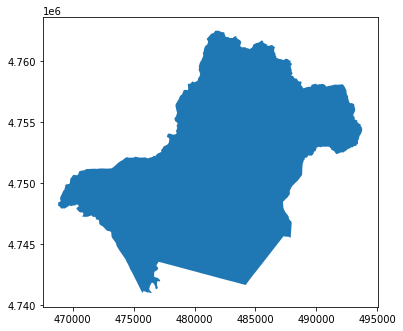

In [12]:
#画像に合わせて投影変換
out_file = os.path.join(shape_path + "re_N03-20_08_200101.shp")
re_shape = shape_srt.to_crs({"init": "epsg:32654"})

#出力
re_shape.to_file(driver="ESRI Shapefile",filename=out_file)
print("done")

#GeoDataFrameを描画
f,ax = plt.subplots(1, figsize=(6,6))
ax = re_shape.plot(axes=ax)
plt.show

In [13]:
for file_title in ziplis:
  print("Start make RGB TIF image " +'<'+ file_title +'>')

  path_A = str(file_title) + '.SAFE/GRANULE/'
  f1 = os.listdir(path_A)
  path_B = str(file_title) + '.SAFE/GRANULE/' + str(f1[0])
  f2 = os.listdir(path_B)
  path_C = str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) + '/IMG_DATA/'
  f3 = os.listdir(path_C)

  b2 = rio.open(str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B02.jp2'))
  b3 = rio.open(str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B03.jp2'))
  b4 = rio.open(str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B04.jp2'))
  
  RGB_path = os.path.join(RGB_dir,'sentinel-2_'+str(f3[0][7:15])+'_RGB.tif')
  

  RGB_colar = rio.open(RGB_path,'w',driver='Gtiff',
                       width=b4.width, height=b4.height,
                       count=3,
                       crs=b4.crs,
                       transform=b4.transform,
                       dtype=rasterio.uint16
                       )
  RGB_colar.write(b2.read(1),3) 
  RGB_colar.write(b3.read(1),2) 
  RGB_colar.write(b4.read(1),1) 
  RGB_colar.close()

  print("---masking---")

  with fiona.open(out_file, "r") as mask:
    masks = [feature["geometry"] for feature in mask]

  with rasterio.open(RGB_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, masks, crop=True)
    out_meta = src.meta

  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

  with rasterio.open(RGB_path, "w", **out_meta) as dest:
    dest.write(out_image)
  
  #画像表示のため8bit形式で書き出し。
  scale = '-scale 0 255 0 15'
  options_list = ['-ot Byte','-of Gtiff',scale]
  options_string = " ".join(options_list)

  gdal.Translate(os.path.join(RGB_dir + "/" + 'sentinel-2_'+str(f3[0][7:15])+'.tif'),os.path.join(RGB_dir + "/" + 'sentinel-2_'+str(f3[0][7:15])+'_RGB.tif'),options = options_string)

  print("Done")

Start make RGB TIF image <S2A_MSIL2A_20200621T012701_N0214_R074_T54TVN_20200621T040143>


RasterioIOError: ignored